In [39]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import os 

sys.path.append('..')
from src import config

if sys.platform == 'linux':
    path = config.LINUX_PATH
else:
    path = config.OS_PATH
os.chdir(path)

data_path = config.STRAVA_TRAIN_PATH
data = pd.read_csv(data_path, index_col=0)
print(data.columns.tolist())
data.head()

['name', 'distance', 'moving_time', 'total_elevation_gain', 'workout_type', 'timezone', 'start_latitude', 'start_longitude', 'achievement_count', 'kudos_count', 'athlete_count', 'photo_count', 'manual', 'max_speed', 'average_heartrate', 'max_heartrate', 'pr_count', 'total_photo_count', 'suffer_score', 'date', 'time', 'run_area', 'latlng_cluster', 'average_speed_mpk']


,name,distance,moving_time,total_elevation_gain,workout_type,timezone,start_latitude,start_longitude,achievement_count,kudos_count,...,average_heartrate,max_heartrate,pr_count,total_photo_count,suffer_score,date,time,run_area,latlng_cluster,average_speed_mpk
260,Pre meet,7.1960,28.383333,3.0,3.0,America/Boise,43.609586,-116.191655,0.0,33.0,...,148.7,173.0,0.0,0.0,16.0,2021-01-29,21:51:05,2.207397,1,3.944615
261,WU,4.8448,22.183333,44.0,0.0,America/Boise,43.610201,-116.191848,0.0,11.0,...,151.0,167.0,0.0,0.0,20.0,2021-01-29,21:08:46,0.166980,1,4.578571
262,Gain train 🚂😈🤪,8.1354,36.100000,10.0,0.0,America/Boise,43.599624,-116.190932,0.0,32.0,...,148.2,164.0,0.0,0.0,26.0,2021-01-29,16:01:32,5.870196,1,4.437167
263,"Not 10, sorry Logan",12.9277,59.283333,49.0,0.0,America/Boise,43.610229,-116.191785,2.0,44.0,...,150.2,165.0,0.0,0.0,52.0,2021-01-28,22:39:54,37.574116,1,4.586131
264,😴,6.7834,30.283333,9.0,0.0,America/Boise,43.599342,-116.190412,0.0,27.0,...,153.4,165.0,0.0,0.0,29.0,2021-01-28,14:13:57,4.207750,1,4.464506


# Clustering coordinates

<AxesSubplot:>

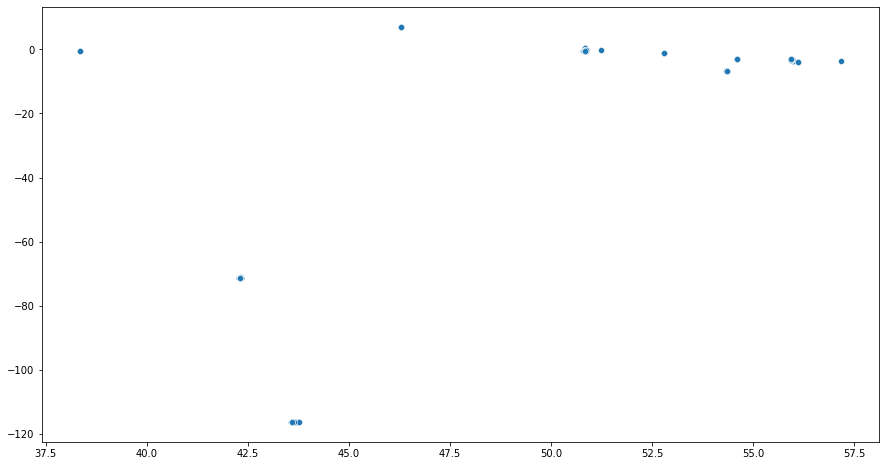

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

data_full = data.dropna(subset=['start_latitude', 'start_longitude'])
lat, lng = data.start_latitude.values, data.start_longitude.values
plt.figure(figsize=(15,8))
sns.scatterplot(x=lat, y=lng)

In [18]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import pickle
# creates 5 clusters using hierarchical clustering.
agc = AgglomerativeClustering(n_clusters =5, affinity='euclidean', linkage='ward')
data_full['pickup_cluster_agc'] = agc.fit_predict(data_full[['start_latitude', 'start_longitude']]) 

# creates 5 clusters using k-means clustering algorithm.
kmeans = KMeans(6)
clusters = kmeans.fit(data_full[['start_latitude', 'start_longitude']])

# with open('models/cluster_latlng', 'wb') as f:
#     pickle.dump(clusters, f)

data_full['pickup_cluster_kmeans'] = clusters.predict(data_full[['start_latitude', 'start_longitude']])

/home/jack/miniconda3/envs/pycaret/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/jack/miniconda3/envs/pycaret/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [84]:
def apply_clustering(df):
    """
    :param df: dataframe that needs lat, lng column clustered 
    :return: cluster
    """
    with open('models/cluster_latlng', 'rb') as f:
        cluster_latlng = pickle.load(f)

    def apply_clustering_helper(lat, lng, cluster_model, num_clusters=6):
        '''
        If there is a latitude and longitude predict the cluster. If not 
        assign to a new cluster.
        :param lat: start latitude of run
        :param lng: start longitude of run 
        :param cluster_model: KMeans clustering model fit on training data
        :param num_clusters: used to assign new cluster to missing data 
        :return: cluster assigned 
        '''
        if not np.isnan(lat) and not np.isnan(lng):# and isinstance(lng, numbers.Number):
                val = np.array([lat,lng]).reshape(1,2)
                cluster = cluster_model.predict(val)[0]
        else:
                cluster = num_clusters
        return cluster 

    df['latlng_cluster'] = df.apply(lambda row: apply_clustering_helper(row['start_latitude'], row['start_longitude'], cluster_latlng), axis=1)
    return df
        
data =  apply_clustering(data) # cluster_latlng.predict(data[['start_latitude', 'start_longitude']])
data.head()

,name,distance,moving_time,total_elevation_gain,workout_type,timezone,start_latitude,start_longitude,achievement_count,kudos_count,...,average_heartrate,max_heartrate,pr_count,total_photo_count,suffer_score,date,time,run_area,average_speed_mpk,latlng_cluster
260,Pre meet,7.1960,28.383333,3.0,3.0,America/Boise,43.609586,-116.191655,0.0,33.0,...,148.7,173.0,0.0,0.0,16.0,2021-01-29,21:51:05,2.207397,3.944615,1
261,WU,4.8448,22.183333,44.0,0.0,America/Boise,43.610201,-116.191848,0.0,11.0,...,151.0,167.0,0.0,0.0,20.0,2021-01-29,21:08:46,0.166980,4.578571,1
262,Gain train 🚂😈🤪,8.1354,36.100000,10.0,0.0,America/Boise,43.599624,-116.190932,0.0,32.0,...,148.2,164.0,0.0,0.0,26.0,2021-01-29,16:01:32,5.870196,4.437167,1
263,"Not 10, sorry Logan",12.9277,59.283333,49.0,0.0,America/Boise,43.610229,-116.191785,2.0,44.0,...,150.2,165.0,0.0,0.0,52.0,2021-01-28,22:39:54,37.574116,4.586131,1
264,😴,6.7834,30.283333,9.0,0.0,America/Boise,43.599342,-116.190412,0.0,27.0,...,153.4,165.0,0.0,0.0,29.0,2021-01-28,14:13:57,4.207750,4.464506,1


<AxesSubplot:xlabel='start_latitude', ylabel='start_longitude'>

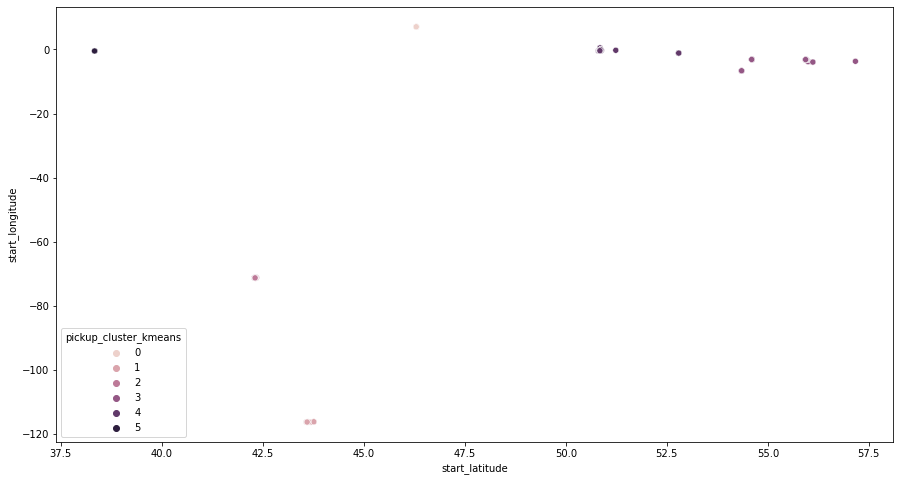

In [19]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=data_full, x="start_latitude", y="start_longitude", hue="pickup_cluster_kmeans")

# Mapping coordinates



In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

data_full = data.dropna(subset=['start_latitude', 'start_longitude'])
lat, lng = data.start_latitude.values, data.start_longitude.values

In [54]:
from geopy.geocoders import Nominatim
# create locator 

def reverse_geocoder(df):
    '''
    reverse geocode the lat, lng coordinates to find the city where the run was
    :param df: dataframe to add new column too
    :return: new dataframe with column 'city'
    '''
    
    geolocator = Nominatim(user_agent='myGeocoder')
    data_full['temp'] = data_full['start_latitude'].map(str) + ',' + data_full['start_longitude'].map(str)

    def reverse_geocode_helper(geom):
        try:
            location = geolocator.reverse(geom)
            city = location.raw.get('address').get('city')
            if not city:
                city = location.raw.get('address').get('town')
        except:
            city = np.nan
        return city
    
    df['city'] = df['temp'].apply(reverse_geocode_helper)
    df = df.drop('temp', axis=1)
    return df


data_full = reverse_geocoder(data_full)
data_full.head()

/home/jack/miniconda3/envs/pycaret/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,name,distance,moving_time,total_elevation_gain,workout_type,timezone,start_latitude,start_longitude,achievement_count,kudos_count,...,max_heartrate,pr_count,total_photo_count,suffer_score,date,time,run_area,latlng_cluster,average_speed_mpk,city
260,Pre meet,7.1960,28.383333,3.0,3.0,America/Boise,43.609586,-116.191655,0.0,33.0,...,173.0,0.0,0.0,16.0,2021-01-29,21:51:05,2.207397,1,3.944615,Boise
261,WU,4.8448,22.183333,44.0,0.0,America/Boise,43.610201,-116.191848,0.0,11.0,...,167.0,0.0,0.0,20.0,2021-01-29,21:08:46,0.166980,1,4.578571,Boise
262,Gain train 🚂😈🤪,8.1354,36.100000,10.0,0.0,America/Boise,43.599624,-116.190932,0.0,32.0,...,164.0,0.0,0.0,26.0,2021-01-29,16:01:32,5.870196,1,4.437167,Boise
263,"Not 10, sorry Logan",12.9277,59.283333,49.0,0.0,America/Boise,43.610229,-116.191785,2.0,44.0,...,165.0,0.0,0.0,52.0,2021-01-28,22:39:54,37.574116,1,4.586131,Boise
264,😴,6.7834,30.283333,9.0,0.0,America/Boise,43.599342,-116.190412,0.0,27.0,...,165.0,0.0,0.0,29.0,2021-01-28,14:13:57,4.207750,1,4.464506,Boise
